In [1]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR



In [2]:
# Modelling options for the loop


d1 = {'NO L1&L1': [0.,0.,'model'],
      'L1 Only': [1e-04,0.,'model'], 
      'L2 Only': [0.,1e-04,'model'],
      'L1&L2':[1e-04,1e-04,'model'],
      'GBN Only': [0,0,'model2'],
      'GBN with L1 and L2':[1e-04,1e-04,'model2']}

#initializers 
dropout_value = 0.05
num_splits=2
EPOCHS = 25

metric_values = {}
models={}




In [3]:
# Transforms

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
                                       ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [4]:
# download data
train = datasets.MNIST('./data',train=True,transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform =test_transforms, download=True)

In [5]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

# torch.manual_seed(SEED)

# if cuda:
#   torch.cuda.manual_seed(SEED)

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


torch.Size([128, 1, 28, 28]) torch.Size([1, 28, 28])
(28, 28)


Text(0.5, 1.0, '4')

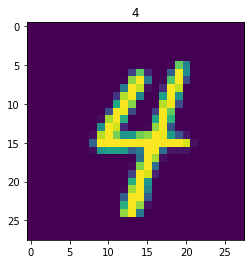

In [6]:
# Visualize Data

dataiter = iter(train_loader)
images,labels = dataiter.next()

print(images.shape, images[0].shape)

print(images[0].numpy().squeeze().shape) # squeeze removes the channel value. 
%matplotlib inline
plt.imshow(images[0].numpy().squeeze())
plt.title(labels[0].item()) #item converts from tensor to value

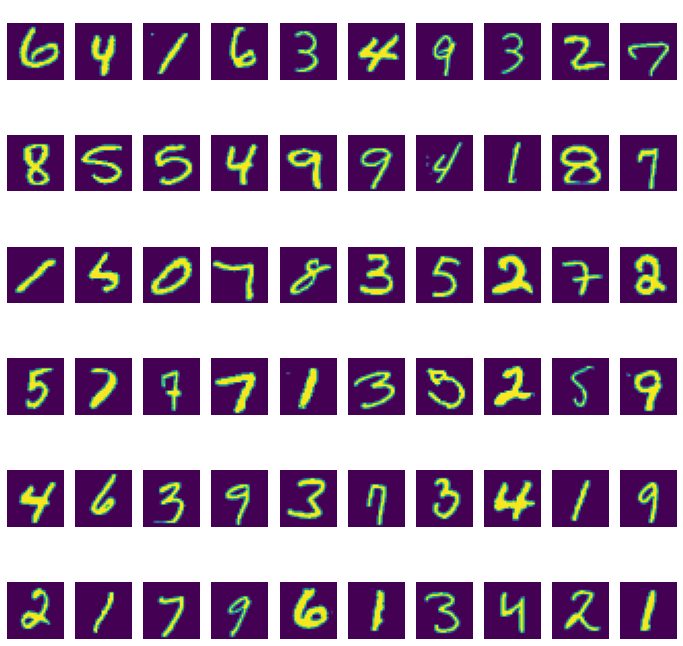

In [7]:
# visualize data in grid format

figure = plt.figure(figsize=(12,12))
num_of_images = 60

for index in range(1, num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze())
  plt.title(labels[index].item(),color='w')

# Network with and without GBN

In [8]:
# Model Architecture - No GBN

# dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() ,
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value) 
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )


        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 5

    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

In [9]:
# num_splits=2

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [10]:
# GBN Architecture


class Net_GBN(nn.Module):
    def __init__(self):
        super(Net_GBN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
           nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value) 
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )


        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 5

    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net_GBN().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
    GhostBatchNorm-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
             ReLU-10           [-1, 16, 22, 22]               0
   GhostBatchNorm-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

# MODULAR

In [11]:
# Modular PRogramming

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm


class Trainer():
  '''Trainer Classe '''
  
  def __init__(self,model,device,train_loader,test_loader,optimizer,epoch,schedul):
    self.model = model
    self.device= device
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.optimizer = optimizer
    self.epoch = epoch
    self.scheduler = schedul


  def train(self,l1_lambda=0, l2_lambda=0):

    self.l1_lambda = l1_lambda
    self.l2_lambda = l2_lambda

    comb_train_losses = []
    comb_train_acc    = []
    comb_test_losses  = []
    comb_test_acc     = []
    # EPOCHS = 10
    for epoch in range(self.epoch):
        
        print("EPOCH:", epoch)
        print('learning rate ', self.scheduler.get_lr())

        # trainer = Trainer(model,device,train_loader,test_loader,optimizer,epoch)

        train_ac, train_los = trainer.train_mod()
        scheduler.step()    
        test_ac, test_los = trainer.test_mod()

        comb_train_losses.extend(train_los)
        comb_train_acc.extend(train_ac)
        comb_test_losses.extend(test_los)
        comb_test_acc.extend(test_ac)
    return ((comb_train_acc,comb_train_losses),(comb_test_acc,comb_test_losses)) 

  def train_mod(self):

    train_losses = []
    train_acc = []
    
    self.model.train()
    pbar = tqdm(self.train_loader)

    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(self.device), target.to(self.device)

      # Init
      self.optimizer.zero_grad()

      # Predict
      y_pred = self.model(data)

      # Calculate loss

      criterion = F.nll_loss(y_pred, target)

      # l1 regularization
      l1_reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])

      # l2 regularization
      l2_reg_loss = sum([torch.sum(param**2) for param in model.parameters()])


      #Calculate loss (depending on which decay parameter passed, regularization is calculated. )

      loss = criterion + self.l1_lambda * l1_reg_loss + self.l2_lambda*l2_reg_loss
     
      train_losses.append(loss)

      # Backpropagation
      loss.backward()
      self.optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)
    return (train_acc,train_losses)



  def test_mod(self):
    test_losses = []
    test_acc = []
    self.model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in self.test_loader:
            data, target = data.to(self.device), target.to(self.device)
            output = self.model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return (test_acc,test_losses)


    

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# plt.style.use("dark_background")

def plot_metrics(train_metric,test_metric):
  (train_acc, train_losses) = train_metric
  (test_acc, test_losses) = test_metric


  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss",color='r')
  axs[1, 0].plot(train_acc[500:])
  axs[1, 0].set_title("Training Accuracy",color='r')
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss",color='r')
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy", color='r')



# Function to plot misclassified images

def plot_misclassified(model,test_loader,device):
  # Visualize the misclassified images
  model.eval()

  figure = plt.figure(figsize=(10,10))
  num_of_images = 25
  index=1

  with torch.no_grad():
    for data,target in test_loader:
      data,target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1,keepdim=True)
      act = target.view_as(pred)
      bool_vec = ~pred.eq(act) # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa

      # now extract the index number from the tensor which has 'true' 
      idx = list(np.where(bool_vec.cpu().numpy())[0])

      if idx: # if not a blank list
        idx_list = idx
        # print(data[idx_list[0]].shape)
        if index < num_of_images+1:
              
            plt.subplot(5,5,index)
            plt.axis('off')
            titl = 'act/pred : ' + str(target[idx[0]].cpu().item()) + '/' + str(pred[idx[0]].cpu().item())
            plt.imshow(data[idx[0]].cpu().numpy().squeeze()) # prints the 1st index of each batch. 
            plt.title(titl)
            index+=1



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:


# # No GBN Network
# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

# # GBN Network
# model2 =  Net_GBN().to(device)
# optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.05)



In [14]:
# d1 = {'NO L1&L1': [0.,0.,model],
#       'L1 Only': [1e-04,0.,model], 
#       'L2 Only': [0.,1e-04,model],
#       'L1&L2':[1e-04,1e-04,model]}

# for x in d1.keys():
#   print(d1[x][2])

# RUN ALL MODELS IN LOOP

In [ ]:


# print(d1)
for x in d1.keys():
  exp_name = x
  print('\nThis model is for :',exp_name)
  l1 = d1[x][0]
  l2 = d1[x][1]
  model_name = d1[x][2]
  # modelo = d1[x][3]

  if model_name == 'model':
      
    print('\n model name:',model_name)
    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.05)
    trainer = Trainer(model,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
    train_metric, test_metric = trainer.train(l1_lambda=l1, l2_lambda=l2)

  elif model_name == 'model2':
    print('\n model name:',model_name)
    model2 =  Net_GBN().to(device)
    optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.05)
    trainer = Trainer(model2,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
    train_metric, test_metric = trainer.train(l1_lambda=l1, l2_lambda=l2)


  # save the metrics in dictionary

  metric_values[exp_name] = (train_metric, test_metric)

  # print(x,d1[x][0],d1[x][1],d1[x][2])

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]


This model is for : NO L1&L1

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.14140649139881134 Batch_id=468 Accuracy=89.16: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9836/10000 (98.36%)

EPOCH: 1
learning rate  [0.01]


Loss=0.11176630109548569 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9838/10000 (98.38%)

EPOCH: 2
learning rate  [0.01]


Loss=0.02320156805217266 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9899/10000 (98.99%)

EPOCH: 3
learning rate  [0.01]


Loss=0.0244649276137352 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9916/10000 (99.16%)

EPOCH: 4
learning rate  [0.01]


Loss=0.010932604782283306 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

EPOCH: 5
learning rate  [0.01]


Loss=0.044222552329301834 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9922/10000 (99.22%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.015920063480734825 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.007312451023608446 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.008586402051150799 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.06782665848731995 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.015859583392739296 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.10766201466321945 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.01951437257230282 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.025401271879673004 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.006264981348067522 Batch_id=299 Accuracy=99.19:  64%|██████▍   | 300/469 [00:09<00:05, 33.07it/s]

In [ ]:
# plot Loss for all models

plt.figure(figsize=(8,6))
plt.title('validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
for idx,exp_name in enumerate(metric_values.keys()):
  train_metric,test_metric = metric_values[exp_name]
  train_acc,train_loss = train_metric
  test_acc,test_loss = test_metric
  plt.plot(test_loss,label='{}'.format(exp_name))
plt.legend()
plt.show()

In [ ]:
# plot accuracy for all models

plt.figure(figsize=(8,6))
plt.title('validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
for idx,exp_name in enumerate(metric_values.keys()):
  train_metric,test_metric = metric_values[exp_name]
  train_acc,train_loss = train_metric
  test_acc,test_loss = test_metric
  plt.plot(test_acc,label='{}'.format(exp_name))
plt.legend()
plt.show()

# Plot misclassified

In [ ]:
plot_misclassified(model2,test_loader,device)